# Regularisation Technique

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from scipy.special import boxcox1p
from sklearn.preprocessing import StandardScaler

import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

# Modeling packages
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

1. Data Preparation

In [13]:
df_train = pd.read_csv("train.csv")
print(df_train.shape)

df_test = pd.read_csv("test.csv")
print(df_test.shape)

(1460, 81)
(1459, 80)


In [14]:
# Id column does not affect the prediction outcome hence can be dropped. However the Id serieses are saved for future modeling
test_id = df_test['Id']
train_id = df_train['Id']

# Dropping Id column
df_test.drop("Id", axis = 1, inplace = True)
df_train.drop("Id", axis = 1, inplace = True)

In [15]:
#Target Feature Normalization
original = df_train['SalePrice']
df_train['SalePrice'] = stats.boxcox(df_train['SalePrice'])[0]

In [16]:
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
(mu_norm, sigma_norm) = norm.fit(df_train['SalePrice'])

# Get Skewness and Kurtosis 
original_skew = original.skew()
original_kurt = original.kurt()

transf_skew = df_train['SalePrice'].skew()
transf_kurt = df_train['SalePrice'].kurt()

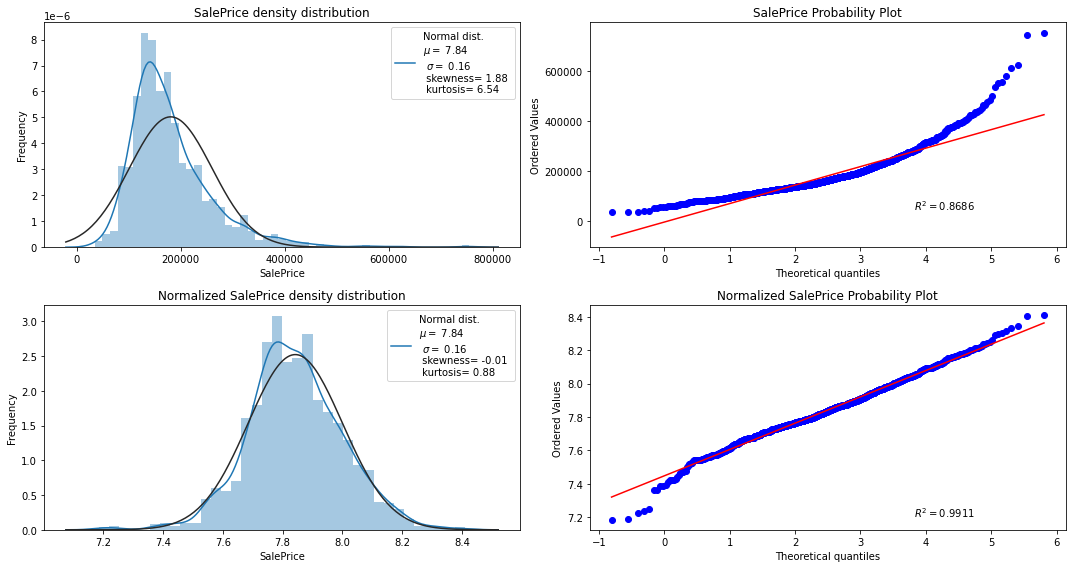

In [17]:
plt.figure(figsize=(15,8))

#Now plot the distribution
plt.subplot(221)
sns.distplot(original , fit=norm)
plt.legend(['Normal dist. \n$\mu=$ {:.2f} \n $\sigma=$ {:.2f} \n skewness= {:.2f} \n kurtosis= {:.2f}'.format(mu, sigma,original_skew,original_kurt)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice density distribution')

#Get also the QQ-plot
plt.subplot(222)
res = stats.probplot(original, sparams=(2.5,), plot=plt, rvalue=True)
plt.title('SalePrice Probability Plot')

#Now plot Normalized distribution
plt.subplot(223)
sns.distplot(df_train['SalePrice'] , fit=norm)
plt.legend(['Normal dist. \n$\mu=$ {:.2f} \n $\sigma=$ {:.2f} \n skewness= {:.2f} \n kurtosis= {:.2f}'.format(mu_norm, sigma_norm,transf_skew,transf_kurt)],loc='best')

plt.ylabel('Frequency')
plt.title('Normalized SalePrice density distribution')

#Get also the QQ-plot for Normalized distribution
plt.subplot(224)
res = stats.probplot(df_train['SalePrice'], sparams=(2.5,), plot=plt, rvalue=True)
plt.title('Normalized SalePrice Probability Plot')
plt.tight_layout()

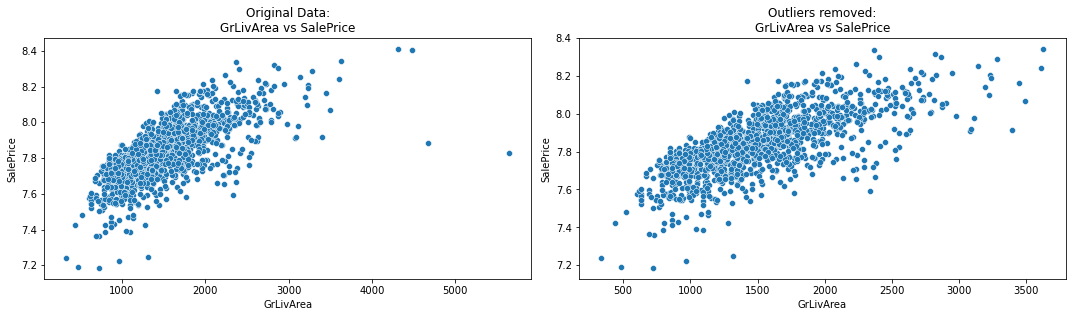

In [18]:
#Removing Outliers
plt.figure(figsize=(15,8))
plt.subplot(221)
sns.scatterplot(x=df_train['GrLivArea'],y=df_train['SalePrice'])
plt.title('Original Data:\nGrLivArea vs SalePrice')

# Removing two outliers with larger living area and low sale price
df_train = df_train.drop(df_train.sort_values(by = 'GrLivArea', ascending = False)[:4].index)

plt.subplot(222)
sns.scatterplot(x=df_train['GrLivArea'],y=df_train['SalePrice'])
plt.title('Outliers removed:\nGrLivArea vs SalePrice')

plt.tight_layout()

In [19]:
# Combining Train and Test data sets
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)


ntrain = df_train.shape[0]                        # Will use this to generate a new train data set 
ntest = df_test.shape[0]                          # Will use this to generate a new test data set
y_train = df_train['SalePrice'].values
y_test = df_train['SalePrice'].values 

Text(0.5, 1.0, 'Missing Data')

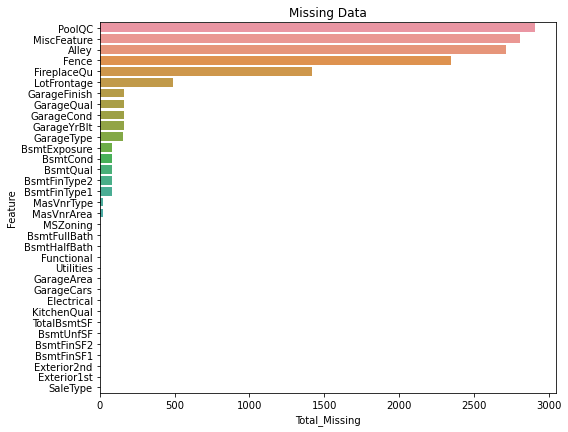

In [21]:
#Missing Value Imputation
def report_missing_data(df):
    '''
    IN: Dataframe 
    OUT: Dataframe with reported count of missing values, % missing per column and per total data
    '''
    
    missing_count_per_column = df.isnull().sum()
    missing_count_per_column = missing_count_per_column[missing_count_per_column>0]
    total_count_per_column = df.isnull().count()
    total_cells = np.product(df.shape)
    
    # Percent calculation
    percent_per_columnn = 100*missing_count_per_column/total_count_per_column
    percent_of_total = 100*missing_count_per_column/total_cells
    
    # Creating new dataframe for reporting purposes only
    missing_data = pd.concat([missing_count_per_column,
                              percent_per_columnn,
                              percent_of_total], axis=1, keys=['Total_Missing', 'Percent_per_column','Percent_of_total'])
    
    missing_data = missing_data.dropna()
    missing_data.index.names = ['Feature']
    missing_data.reset_index(inplace=True)

    
    
    return missing_data.sort_values(by ='Total_Missing',ascending=False)


df = report_missing_data(all_data)
plt.figure(figsize=(18,15))
plt.subplot(221)
sns.barplot(y='Feature',x='Total_Missing',data=df)
plt.title('Missing Data')

In [22]:
Cat_toNone = ('PoolQC','Fence','MiscFeature','Alley','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
              'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','MasVnrType','MSSubClass')
    
Cat_toMode = ('MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd','Utilities','SaleType','Functional')

Num_toZero = ('GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath',
              'GarageYrBlt','MasVnrArea')

for col in Cat_toNone:
    all_data[col]=all_data[col].fillna('None')

for col in Cat_toMode:
    all_data[col]=all_data[col].fillna(all_data[col].mode()[0])
    
for col in Num_toZero:
    all_data[col]=all_data[col].fillna(0)

In [23]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
report_missing_data(all_data)

,Feature,Total_Missing,Percent_per_column,Percent_of_total


In [24]:
#Feature Engineering
all_data._get_numeric_data()
all_data['Total_SF'] = all_data['1stFlrSF']+all_data['2ndFlrSF']+all_data['TotalBsmtSF']+all_data['GarageArea']+all_data['GrLivArea']+all_data['PoolArea']+all_data['WoodDeckSF']

In [25]:
#Skewed features transformation
def bcox_transform(df):
    '''
    IN: Original dataframe 
    OUT: Dataframe with box-cox normalized numerical values. 
    Specified skewness threshold 1 and -1 
    '''
    lam = 0.15
    for feat in df._get_numeric_data():
        if df[feat].skew()>1.0 or df[feat].skew()<-1.0:
            df[feat]=boxcox1p(df[feat], lam)
    return df

all_data = bcox_transform(all_data)

In [26]:
#getting dummie variable
all_data = pd.get_dummies(all_data)

In [27]:
# splitting data back to train and test data sets
df_train = all_data[:ntrain]
df_test = all_data[ntrain:]

2. Modeling

In [28]:
X_train = all_data[:df_train.shape[0]]
X_test = all_data[df_train.shape[0]:]
y = y_train

In [29]:
#Defining cross-validation
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

n_folds = 15

# K-fold Root Mean Square Error Cross Validation
def k_rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_train.values)
    rmse= np.sqrt(-cross_val_score(model, df_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

To improve Accuracy (low bias) and Precision (low variance) of our models we introduce Regularization (L1 or L2) terms to our regression equations. Regularization allows us to increase bias and lower the variance of the model by increasing the value of hyperparameter λ. Introduction of the initial bias leads to underfitting of the train data set, but optimization of the test data fit.

Ridge Regression

L2 penalized model where the Square Sum of the weights term is added to Ordinary Least Squares cost function. As hyperparameter λ increases Ridge regression introduces more bias into the model, so the training data does not fit well initially, yet overfitting of the test data decreases in the long run. Rigde regression minimizes (penalizes) the effect of irrelevant features as the strength of regularization growth.

LASSO (Least Absolute Shrinkage and Selection Operator):
    
L1 penalized model where Sum of Absolute weights term is added to Ordinary Least Squares cost function. Regularization strength also increases with an increase in λ, however in the case of LASSO, irrelevant feature weights become zero. It is also common to think of LASSO as feature selection model.

ElasticNet Regression:
    
L2 + L1 penalized model where both regularization temrs are added to Ordinary Least Squares cost function. This model was introduced to limit sometimes inaccurate feature selection of LASSO, where relevant features are being zeroed. By adding L2 term to the model, the chances of preserving important features increase. Generally in definition of ElasticNet, the ratio of L1/L2 needs to be specified, yet for many applications it is kept at 0.5.

Defining models

In [30]:
model_ridge = Ridge()
model_lasso = Lasso()
model_elasticNet = ElasticNet(l1_ratio=0.5)

In [31]:
# Tunning hyperparameter
# In this example we use alpha as our hyperparameter lambda. 
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]

# Evaluating models through k-fold cross-validation defined earlier
cv_ridge = [k_rmsle_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

cv_lasso = [k_rmsle_cv(Lasso(alpha = alpha)).mean() for alpha in alphas]

cv_elasticNet = [k_rmsle_cv(ElasticNet(alpha = alpha)).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_elasticNet = pd.Series(cv_elasticNet, index = alphas)

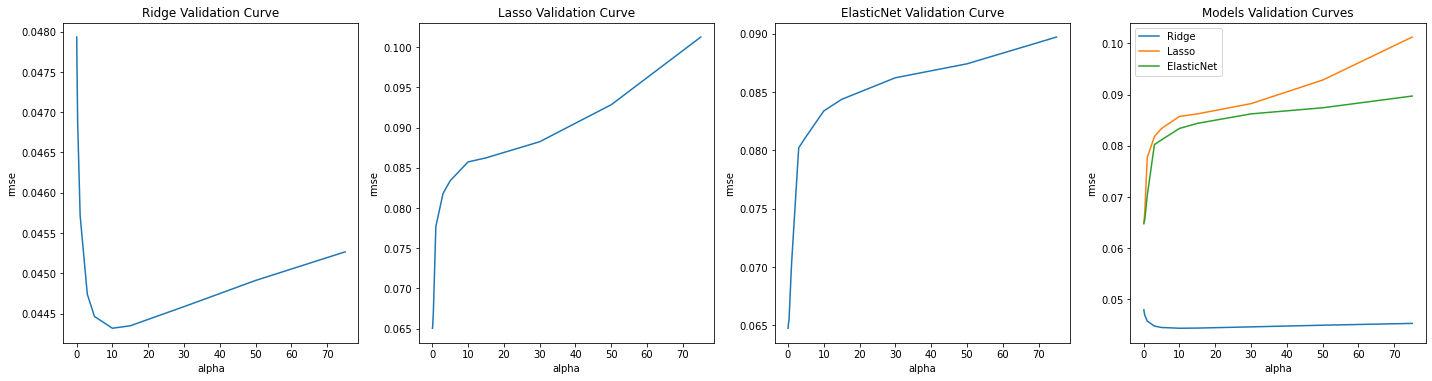

In [32]:
#Plotting model Validation Curves
plt.figure(figsize=(20,10))

plt.subplot(241)
cv_ridge.plot(title = "Ridge Validation Curve")
plt.xlabel("alpha")
plt.ylabel("rmse")

cv_lasso = pd.Series(cv_lasso, index = alphas)
plt.subplot(242)
cv_lasso.plot(title = "Lasso Validation Curve")
plt.xlabel("alpha")
plt.ylabel("rmse")

cv_elasticNet = pd.Series(cv_elasticNet, index = alphas)
plt.subplot(243)
cv_elasticNet.plot(title = "ElasticNet Validation Curve")
plt.xlabel("alpha")
plt.ylabel("rmse")

plt.subplot(244)
cv_ridge.plot()
cv_lasso.plot()
cv_elasticNet.plot()
plt.legend(labels=['Ridge','Lasso','ElasticNet'])
plt.title('Models Validation Curves')
plt.xlabel("alpha")
plt.ylabel("rmse")

plt.tight_layout()

In [33]:
#Model Result Submission
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

model_ridge.fit(df_train, y_train)
model_ridge_pred = model_ridge.predict(df_train)
ridge_pred = np.expm1(model_ridge.predict(df_test.values))

submission = pd.DataFrame()
submission['Id'] = test_id
submission['SalePrice'] = ridge_pred
submission

,Id,SalePrice
0,1461,2255.802698
1,1462,2462.876661
2,1463,2675.664100
3,1464,2758.304273
4,1465,2718.326786
...,...,...
1454,2915,1933.146183
1455,2916,1880.999354
1456,2917,2585.281682
1457,2918,2229.723269
